# Estimating Cosmological Parameters from Galaxy Power Spectrum

In [31]:
# %pip install bayesflow
# %pip install camb
# %pip install dill

In [32]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import bayesflow as bf
import matplotlib.pyplot as plt
import matplotlib
import keras
import camb
import dill
import scipy.stats as stats
from camb import model
import numpy as np

plt.rcParams.update({"font.size": 18})
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)

configs = {
    "flow+lstm": {
        "REGENERATE_TRAIN": False,
        "REGENERATE_TEST": False,
        "RETRAIN": False,
        "FILENAME_TRAIN": "cosmo_train.npy",
        "INFERENCE_NET": bf.networks.FlowMatching(
            subnet_kwargs=dict(widths=(256, 256, 256, 256, 256, 256, 256))
        ),
        "SUMMARY_NET": bf.networks.TimeSeriesNetwork(
            kernel_sizes=12, recurrent_type="lstm"
        ),
        "STANDARDIZE": "all",
        "EPOCHS": 100,
        "REPREDICT_POSTERIOR": False,
        "SIG_NS": 0.3,
    },
    "spline+lstm": {
        "REGENERATE_TRAIN": False,
        "REGENERATE_TEST": True,
        "RETRAIN": True,
        "FILENAME_TRAIN": "cosmo_train.npy",
        "INFERENCE_NET": bf.networks.CouplingFlow(
            transform="spline",
            subnet_kwargs=dict(widths=(256, 256, 256, 256, 256, 256, 256)),
        ),
        "SUMMARY_NET": bf.networks.TimeSeriesNetwork(
            kernel_sizes=12, recurrent_type="lstm"
        ),
        "STANDARDIZE": "all",
        "EPOCHS": 100,
        "REPREDICT_POSTERIOR": True,
        "SIG_NS": 0.3,
    },
    "flow+gru": {
        "REGENERATE_TRAIN": False,
        "REGENERATE_TEST": True,
        "RETRAIN": True,
        "FILENAME_TRAIN": "cosmo_train_all_ok.npy",
        "INFERENCE_NET": bf.networks.FlowMatching(
            subnet_kwargs=dict(widths=(256, 256, 256, 256, 256, 256, 256))
        ),
        "SUMMARY_NET": bf.networks.TimeSeriesNetwork(
            kernel_sizes=12, recurrent_type="gru"
        ),
        "STANDARDIZE": "inference_variables",
        "EPOCHS": 200,
        "REPREDICT_POSTERIOR": True,
        "SIG_NS": 0.2,
    },
    "spline+gru": {
        "REGENERATE_TRAIN": False,
        "REGENERATE_TEST": True,
        "RETRAIN": True,
        "FILENAME_TRAIN": "cosmo_train.npy",
        "INFERENCE_NET": bf.networks.CouplingFlow(
            transform="spline",
            subnet_kwargs=dict(widths=(256, 256, 256, 256, 256, 256, 256)),
        ),
        "SUMMARY_NET": bf.networks.TimeSeriesNetwork(
            kernel_sizes=12, recurrent_type="gru"
        ),
        "STANDARDIZE": "all",
        "EPOCHS": 100,
        "REPREDICT_POSTERIOR": True,
        "SIG_NS": 0.3,
    },
}
config = configs["flow+lstm"]  # Best configuration, change this to switch

## Setting up the simulator

Parameters for n_s prior:
ALPHA_NS: 10.346944444444444, THETA_NS: 0.09326424870466321


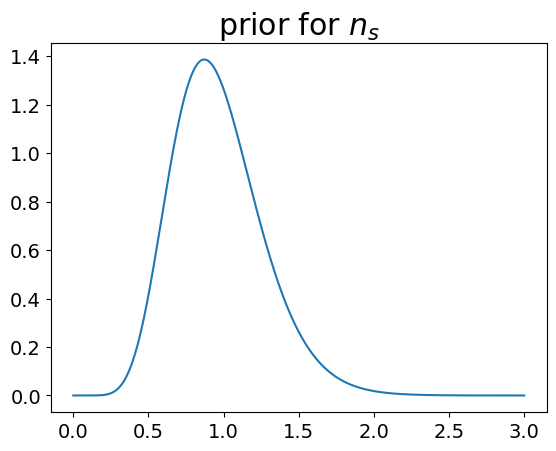

One prior sample:


{'H0': 50.11327299417271,
 'ns': 1.3024247457779847,
 'ommh2': 0.1436534027583721,
 'sig': 900}

In [33]:
# Dataset size for each parameter tuple
N = 200

# Prior parameters:
MU_OMMH2 = 0.1424
MU_NS = 0.965
MU_H0 = 67.4
SIG_OMMH2 = 0.035
SIG_NS = config["SIG_NS"]
SIG_H0 = 10
# Set the mean to MU_NS and variance to SIG_NS^2
# mean(gamma) = alpha * theta, var(gamma) = alpha * theta^2
THETA_NS = SIG_NS**2 / MU_NS
ALPHA_NS = MU_NS / THETA_NS


def prior():
    return dict(
        H0=np.random.normal(MU_H0, SIG_H0),
        ns=np.random.gamma(shape=ALPHA_NS, scale=THETA_NS),
        ommh2=max(np.random.normal(MU_OMMH2, SIG_OMMH2), 0),
        # This makes it easier to also set a prior for sigma_pk
        sig=900,
    )


print("Parameters for n_s prior:")
print(f"ALPHA_NS: {ALPHA_NS}, THETA_NS: {THETA_NS}")
plt.figure()
plt.title("prior for $n_s$")
x_axis = np.linspace(0, 3, 1000)
plt.plot(x_axis, stats.gamma.pdf(x_axis, a=ALPHA_NS, scale=THETA_NS))
plt.show()
print("One prior sample:")
prior()

Model:
$$
\begin{aligned}
\theta &:= (H_0, n_s, \Omega_m)\\
H_0 &\sim \mathcal{N} (67.4,\,10^2)\\
n_s &\sim \mathrm{Gamma} (10.35,\,0.09)\\
\Omega_mh^2 &\sim \mathcal{N} (0.1424,\,0.035^2)\\
y \mathop\vert \theta &\sim \mathcal{N}_{200} (P_k(H_0, n_s, \Omega_m), 900^2I)\\
\end{aligned}
$$

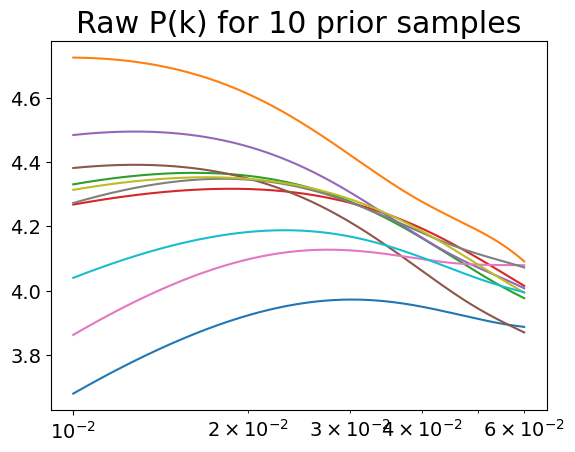

In [34]:
def calculate_pk(H0, ns, ommh2):
    ombh2 = ommh2 * 0.1573033708
    omch2 = ommh2 - ombh2
    par = camb.set_params(H0=H0, ns=ns, ombh2=ombh2, omch2=omch2, kmax=7e-2)
    par.NonLinear = model.NonLinear_none
    results = camb.get_results(par)
    kh, _, pk = results.get_matter_power_spectrum(npoints=N, maxkh=6e-2, minkh=1e-2)
    return kh, pk


# Get the k values once for all plots
kh, _ = calculate_pk(60, 1, 0.1)


# adds gaussian noise to P(k)
def likelihood(H0, ns, ommh2, sig):
    _, pk = calculate_pk(H0, ns, ommh2)
    pk = pk[0, :, np.newaxis]
    if PLOT:
        plt.plot(kh, np.log10(pk))
    pk = pk + np.random.normal(0, sig, pk.shape)
    if np.any(pk <= 0):
        print("Negative P(k) value for parameters")
        print(f"H0: {H0}, ns: {ns}, ommh2: {ommh2}")
        print(f"pk{np.where(pk <= 0)[0]} = {pk[np.where(pk<=0)]}")
        # Regenerate if P(k) is negative
        return likelihood(**prior())
    return dict(pk=np.log10(pk))


simulator = bf.make_simulator([prior, likelihood])

PLOT = True
plt.figure()
plt.title("Raw P(k) for 10 prior samples")
plt.xscale("log")
simulator.sample(10)
plt.show()
PLOT = False

## Load training data

In [35]:
if config["REGENERATE_TRAIN"]:
    np.random.seed(250703)
    train = simulator.sample(1024)
    val = simulator.sample(64)
else:
    data = np.load(config["FILENAME_TRAIN"], allow_pickle=True)[()]
    train = data["train"]
    val = data["val"]

### Plot the prior samples

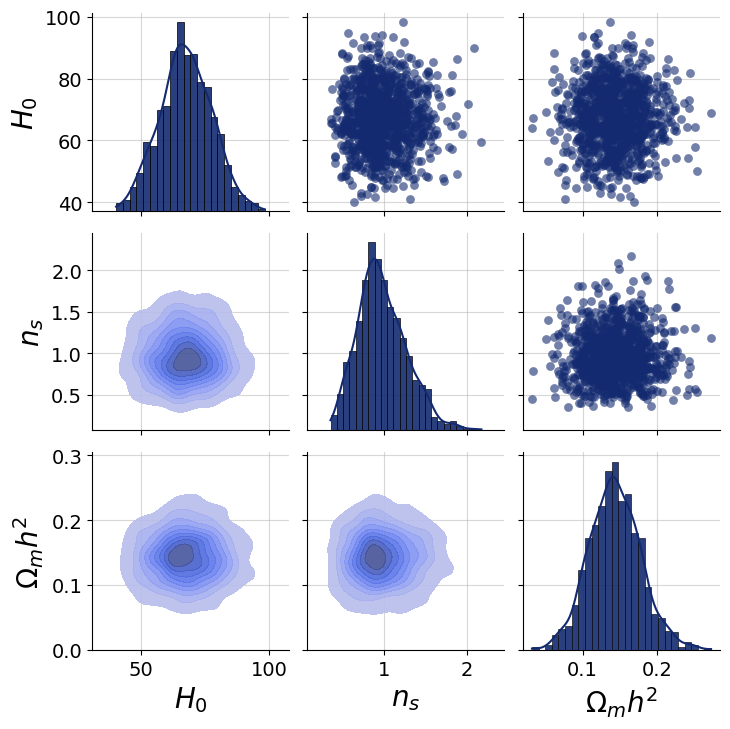

In [36]:
prior2d = bf.diagnostics.plots.pairs_samples(
    train,
    variable_keys=["H0", "ns", "ommh2"],
    variable_names=["$H_0$", "$n_s$", "$\\Omega_mh^2$"],
    diag_sharey=False,
    label_fontsize=20,
    tick_fontsize=14,
)

### Plot the likelihood

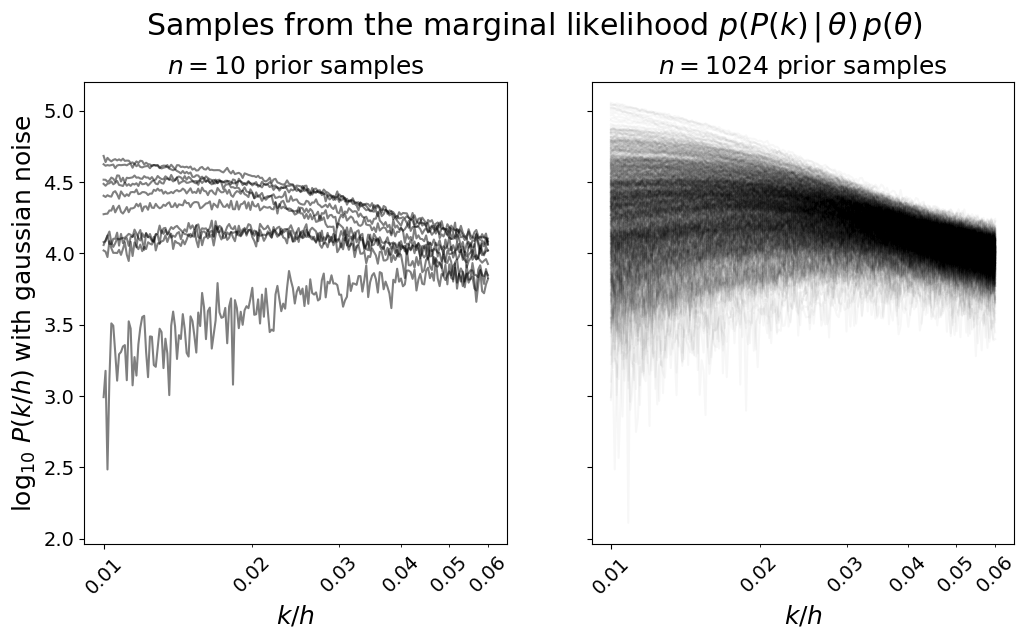

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
fig.suptitle(
    "Samples from the marginal likelihood $p(P(k)\\, \\vert\\, \\theta)\\, p(\\theta)$",
    y=1,
)

ax1.set_xscale("log")
ax1.set_title("$n=10$ prior samples", size=18)
ax1.set_xlabel("$k/h$")
ax1.set_ylabel("$\\log_{10}\\,P(k/h)$ with gaussian noise")
for pk in train["pk"][-10:]:
    ax1.plot(kh, pk, alpha=0.5, color="black")

ax2.set_xscale("log")
ax2.set_title("$n=1024$ prior samples", size=18)
ax2.set_xlabel("$k/h$")
for pk in train["pk"]:
    ax2.plot(kh, pk, alpha=0.03, color="black")

ax1.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
ax1.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
ax1.tick_params(axis="x", labelrotation=45)
ax2.tick_params(axis="x", labelrotation=45)
for label in ax1.xaxis.get_minorticklabels():
    label.set_rotation(45)  # Rotate by 45 degrees
for label in ax2.xaxis.get_minorticklabels():
    label.set_rotation(45)  # Rotate by 45 degrees
plt.show()

## Define the approximator

In [38]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "ns", "ommh2"], into="inference_variables")
    .concatenate(["pk"], into="summary_variables")
    .as_time_series("summary_variables")
)

np.random.seed(2049)

workflow = bf.BasicWorkflow(
    inference_network=config["INFERENCE_NET"],
    summary_network=config["SUMMARY_NET"],
    optimizer=keras.optimizers.Adam(),
    inference_variables=["parameters"],
    summary_variables=["observables"],
    simulator=simulator,
    adapter=adapter,
    standardize=config["STANDARDIZE"],
)

### Check for invalid values and shapes

In [41]:
print(np.argwhere(np.isnan(train["pk"])))
print(val["H0"].shape)
print(train["H0"].shape)
print(train["ns"].shape)
print(train["ommh2"].shape)
print(train["sig"].shape)
print(train["pk"].shape)
print(adapter(train)["inference_variables"].shape)
print(adapter(train)["summary_variables"].shape)

[]
(32, 1)
(1024, 1)
(1024, 1)
(1024, 1)
(1024, 1)
(1024, 200, 1)
(1024, 3)
(1024, 200, 1)


## Train or load the model

In [42]:
if config["RETRAIN"]:
    history = workflow.fit_offline(
        data=train,
        epochs=config["EPOCHS"],
        batch_size=128,
        validation_data=val,
    )
    loss = bf.diagnostics.plots.loss(history)
else:
    with open("model_flow_lstm.pkl", "rb") as file:
        workflow = dill.load(file)

## Diagnostics

### Load test data

In [43]:
if config["REGENERATE_TEST"]:
    np.random.seed(392002)
    plot_test_data = simulator.sample(64)
else:
    plot_test_data = np.load("cosmo_test.npy", allow_pickle=True)[()]

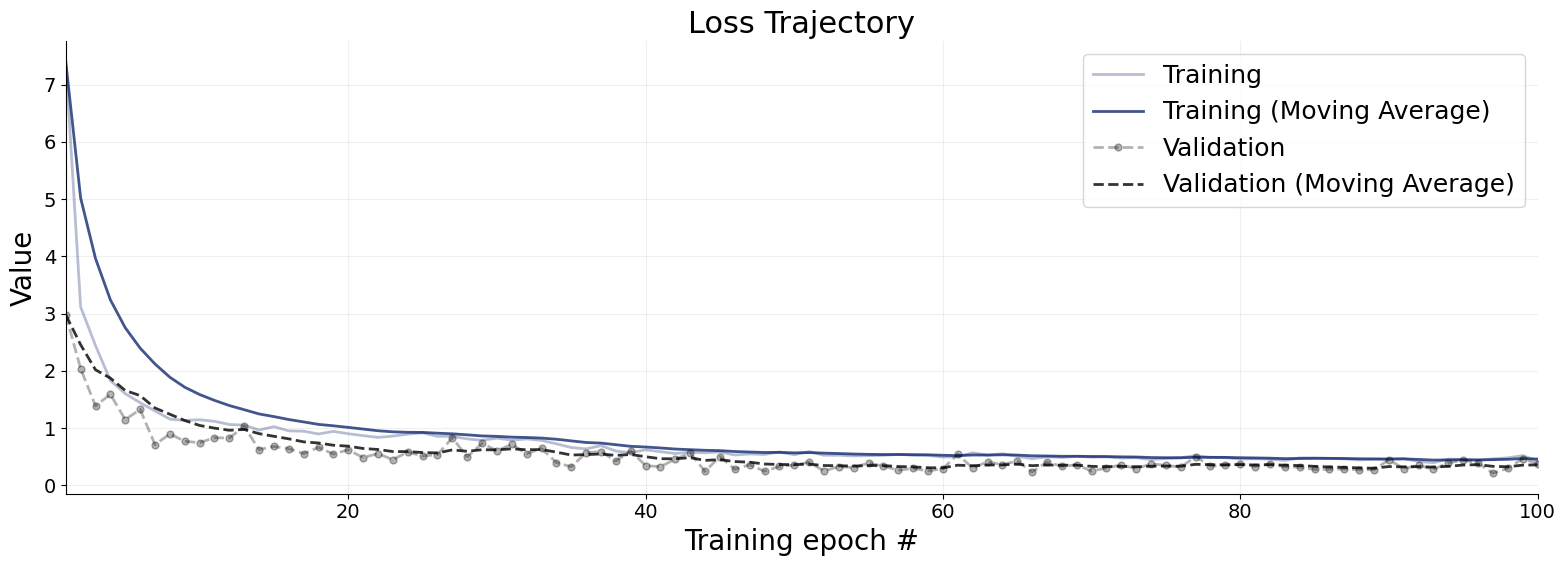

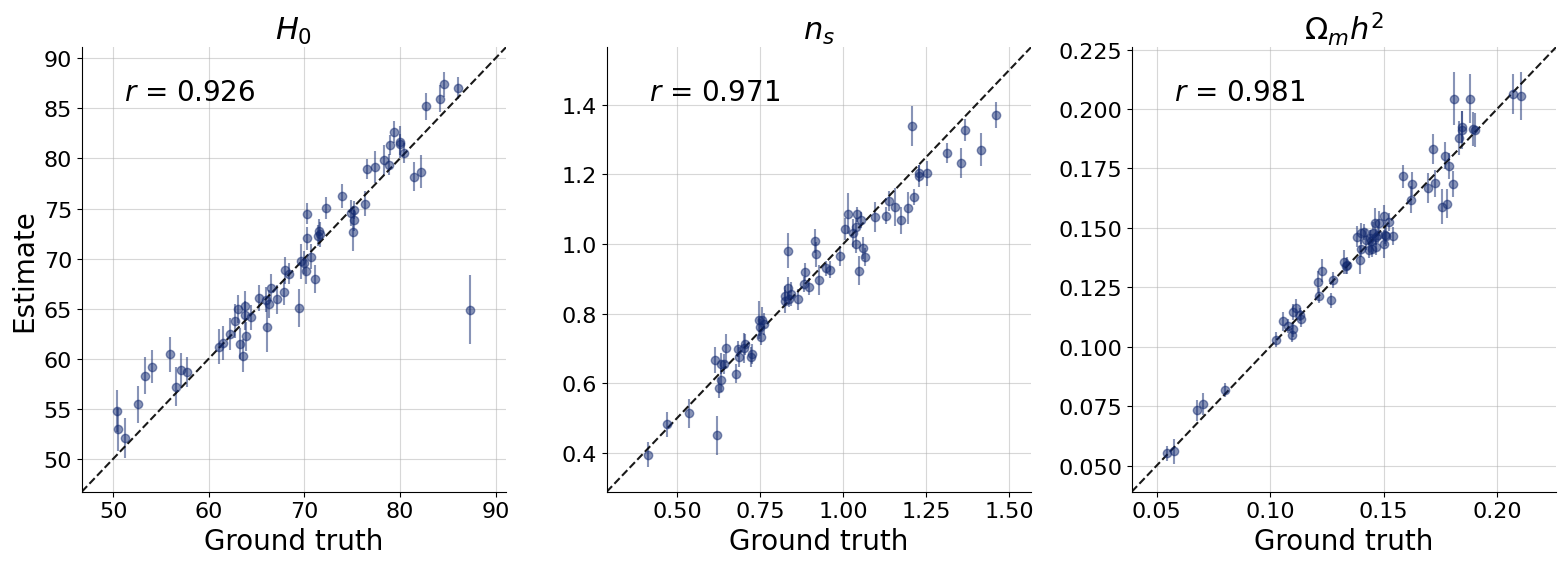

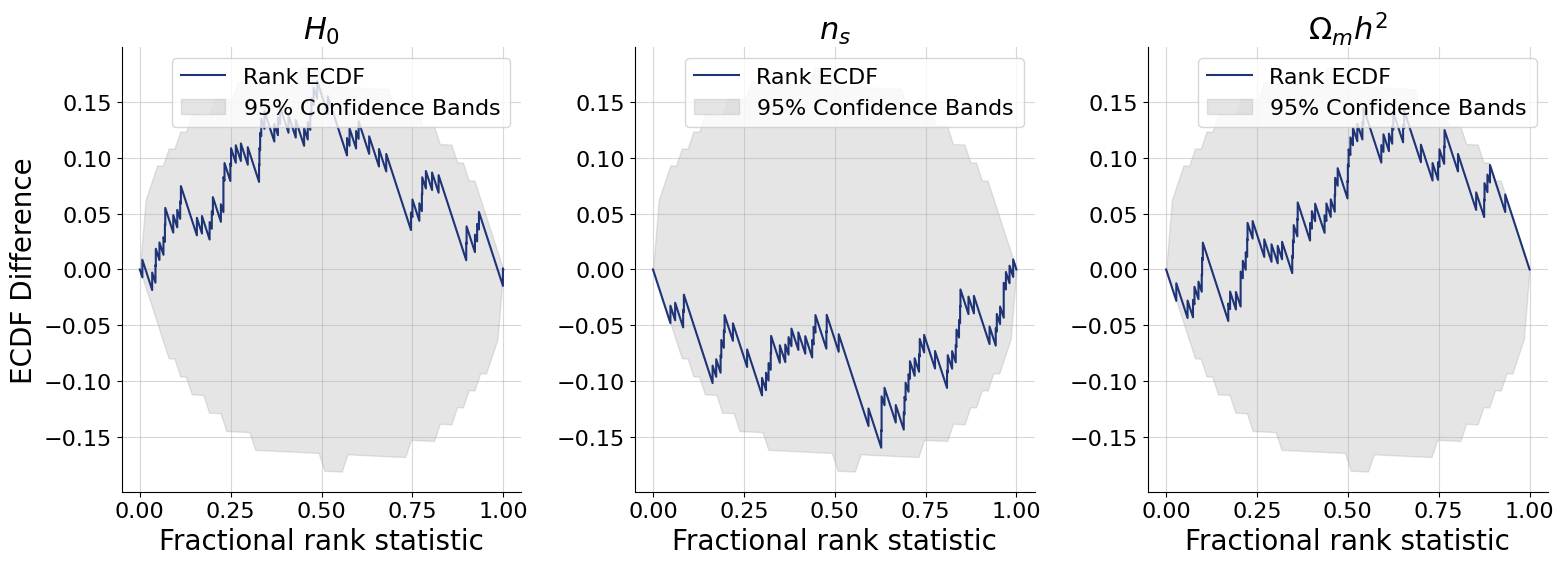

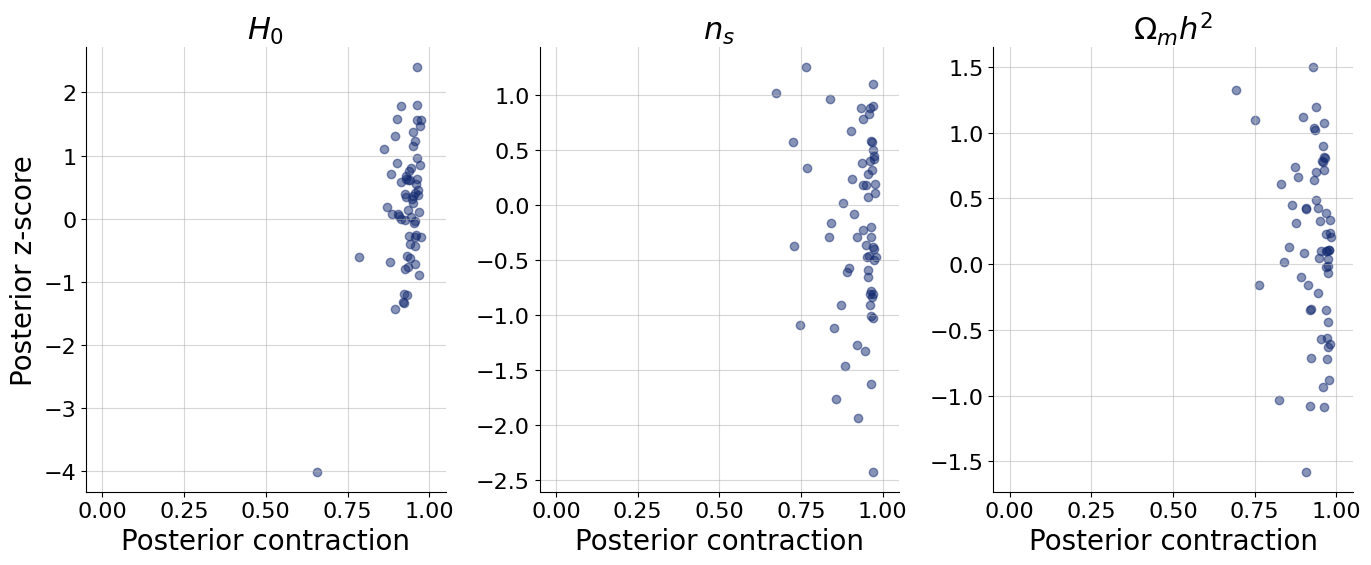

In [44]:
diagnostics = workflow.plot_default_diagnostics(
    test_data=plot_test_data,
    loss_kwargs=dict(
        label_fontsize=20,
        title_fontsize=22,
        legend_fontsize=18,
        figsize=(16, 6),
    ),
    recovery_kwargs=dict(
        label_fontsize=20,
        title_fontsize=22,
        metric_fontsize=20,
        tick_fontsize=16,
        figsize=(16, 6),
    ),
    z_score_contraction_kwargs=dict(
        label_fontsize=20, title_fontsize=22, tick_fontsize=16, figsize=(14, 6)
    ),
    calibration_ecdf_kwargs=dict(
        difference=True,
        label_fontsize=20,
        title_fontsize=22,
        legend_fontsize=16,
        tick_fontsize=16,
        figsize=(16, 6),
    ),
    variable_keys=["H0", "ns", "ommh2"],
    variable_names=["$H_0$", "$n_s$", "$\\Omega_mh^2$"],
)

## Posterior predictive checks

In [45]:
TRUE_MU_OMMH2 = 0.1424
TRUE_MU_NS = 0.965
TRUE_MU_H0 = 67.4
TRUE_SIG_OMMH2 = 0.035
TRUE_SIG_NS = 0.3
TRUE_SIG_H0 = 10
# Set the mean to MU_NS and variance to SIG_NS^2
# mean(gamma) = alpha * theta, var(gamma) = alpha * theta^2
TRUE_THETA_NS = TRUE_SIG_NS**2 / TRUE_MU_NS
TRUE_ALPHA_NS = TRUE_MU_NS / TRUE_THETA_NS


# True prior according to Planck results:
def true_prior():
    return dict(
        H0=np.random.normal(TRUE_MU_H0, TRUE_SIG_H0),
        ns=np.random.gamma(shape=TRUE_ALPHA_NS, scale=TRUE_THETA_NS),
        ommh2=max(np.random.normal(TRUE_MU_OMMH2, TRUE_SIG_OMMH2), 0),
        sig=900,
    )


def const_prior():
    return dict(H0=TRUE_MU_H0, ns=TRUE_MU_NS, ommh2=TRUE_MU_OMMH2, sig=900)


def posterior_predictive(real_data):
    return lambda size: workflow.sample(
        num_samples=size, conditions=dict(pk=adapter(real_data)["summary_variables"])
    )


const_simulator = bf.make_simulator([const_prior, likelihood])

### Inference on 1024 samples from constant prior and likelihood

In [46]:
np.random.seed(389)
const_data = const_simulator.sample(1)
posterior_const = posterior_predictive(const_data)

if config["REPREDICT_POSTERIOR"]:
    np.random.seed(389274)
    posterior_const_samples = posterior_const(1024)
    np.save("cosmo_posterior_const.npy", posterior_const_samples)
else:
    posterior_const_samples = np.load("cosmo_posterior_const.npy", allow_pickle=True)[
        ()
    ]

### Plotting prior vs posterior

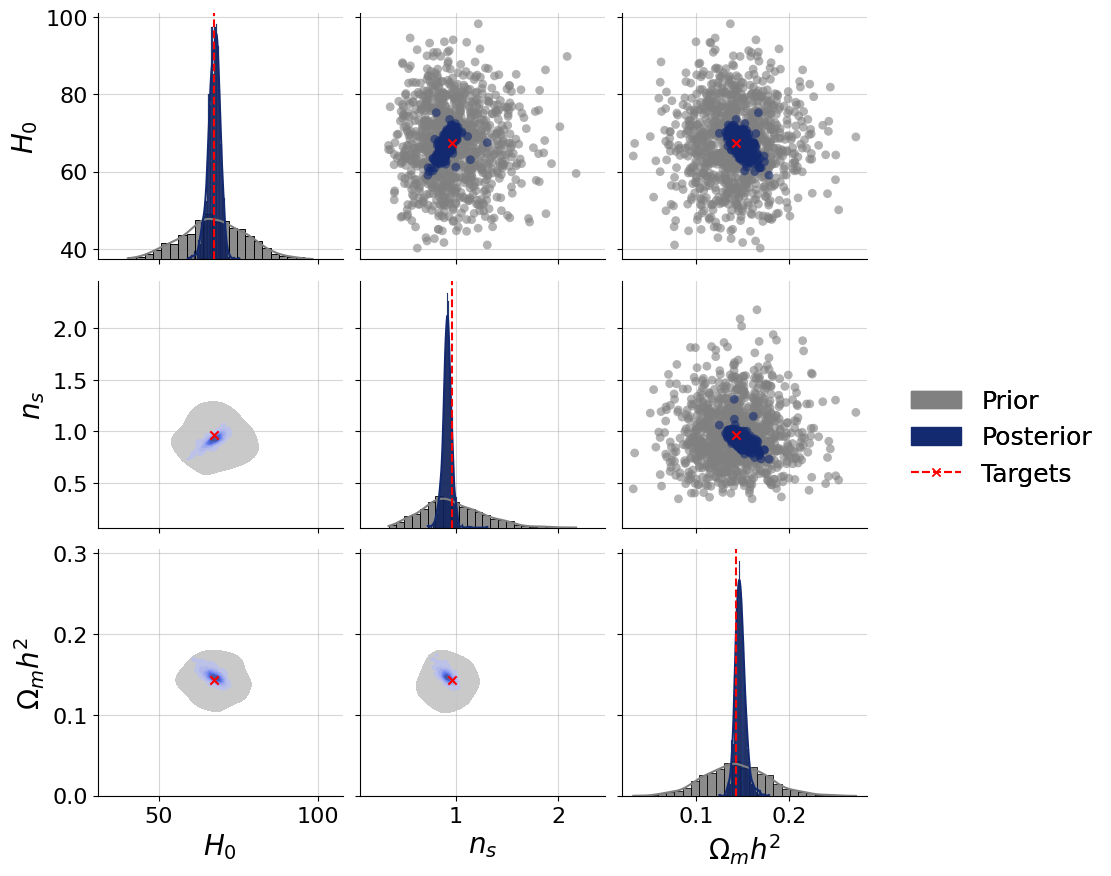

In [47]:
posterior2d = bf.diagnostics.plots.pairs_posterior(
    estimates=posterior_const_samples,
    targets=const_data,
    priors=train,
    variable_keys=["H0", "ns", "ommh2"],
    variable_names=["$H_0$", "$n_s$", "$\\Omega_mh^2$"],
    diag_sharey=False,
    label_fontsize=20,
    tick_fontsize=16,
    legend_fontsize=18,
)